<a href="https://colab.research.google.com/github/mokshada335/scproject/blob/master/food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
imbikramsaha_food11_path = kagglehub.dataset_download('imbikramsaha/food11')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/food11/food11'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food11/food11/test/omelette/122397.jpg
/kaggle/input/food11/food11/test/omelette/84313.jpg
/kaggle/input/food11/food11/test/omelette/234922.jpg
/kaggle/input/food11/food11/test/omelette/299730.jpg
/kaggle/input/food11/food11/test/omelette/108599.jpg
/kaggle/input/food11/food11/test/omelette/127217.jpg
/kaggle/input/food11/food11/test/omelette/315169.jpg
/kaggle/input/food11/food11/test/omelette/79767.jpg
/kaggle/input/food11/food11/test/omelette/54891.jpg
/kaggle/input/food11/food11/test/omelette/29620.jpg
/kaggle/input/food11/food11/test/omelette/162301.jpg
/kaggle/input/food11/food11/test/omelette/94651.jpg
/kaggle/input/food11/food11/test/omelette/176.jpg
/kaggle/input/food11/food11/test/omelette/73939.jpg
/kaggle/input/food11/food11/test/omelette/291775.jpg
/kaggle/input/food11/food11/test/omelette/55053.jpg
/kaggle/input/food11/food11/test/omelette/193872.jpg
/kaggle/input/food11/food11/test/omelette/22850.jpg
/kaggle/input/food11/food11/test/omelette/242516.jpg
/kag

# Imports

In [ ]:
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Normalization, Input
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing # import RandomFlip, RandomRotation, RandomBrightness, RandomContrast

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 1


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (256,256)
train_path='/kaggle/input/food11/food11/train'
test_path='/kaggle/input/food11/food11/test'

data = ImageDataGenerator(rescale = 1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
train_dataset = image_dataset_from_directory(train_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(train_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)
train_dataset.class_names


Found 9900 files belonging to 11 classes.
Using 7920 files for training.
Found 9900 files belonging to 11 classes.
Using 1980 files for validation.


['apple_pie',
 'cheesecake',
 'chicken_curry',
 'french_fries',
 'fried_rice',
 'hamburger',
 'hot_dog',
 'ice_cream',
 'omelette',
 'pizza',
 'sushi']

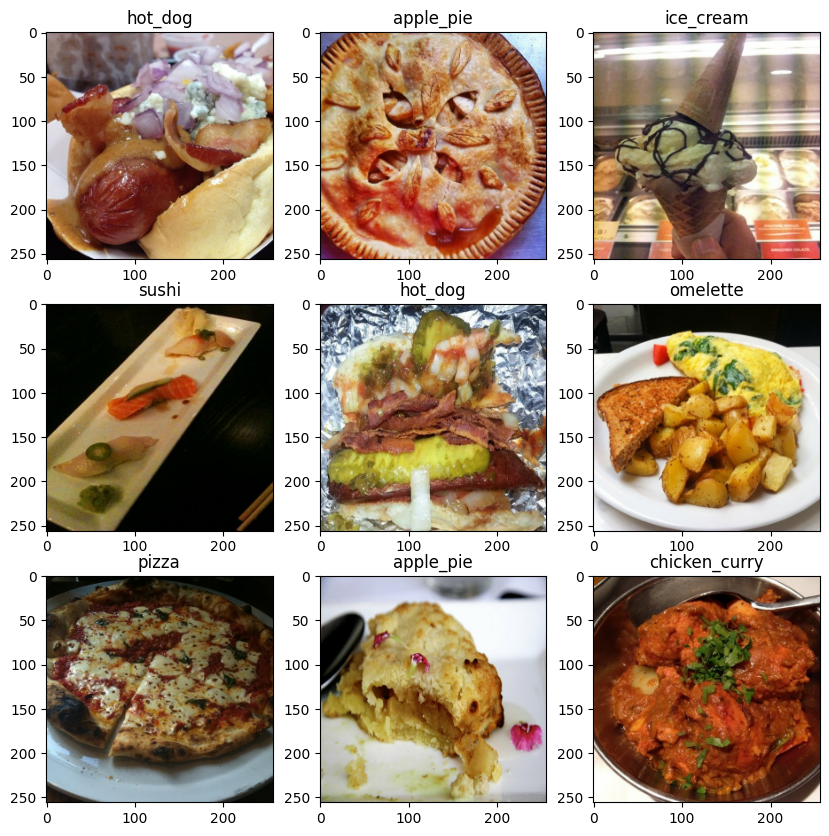

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("on")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmenter():
    data_augmentation = Sequential([
      preprocessing.RandomFlip('horizontal', seed = 42),
      preprocessing.RandomRotation(0.2, seed = 42),
      preprocessing.RandomHeight(0.2, seed = 42),
      preprocessing.RandomWidth(0.2, seed = 42),
      preprocessing.RandomZoom(0.2, seed = 42)])
    return data_augmentation

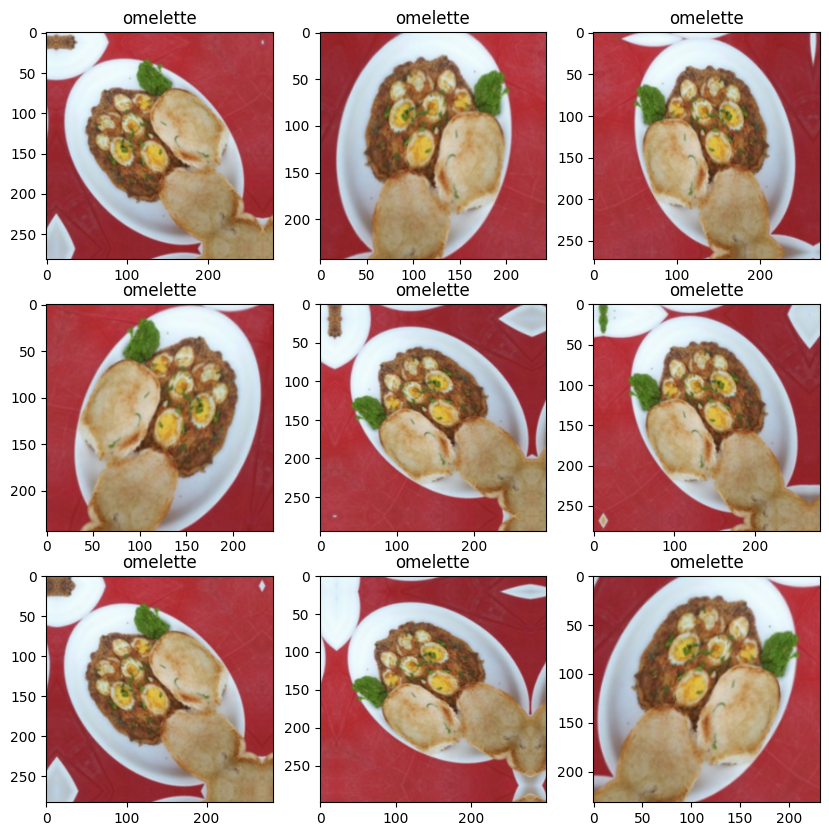

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#         augmented_image_with_brightness = random_brightness(augmented_image)
#         augmented_image_with_brightness_and_contrast = random_contrast(augmented_image_with_brightness)
        plt.imshow(augmented_image[0] / 255)
        plt.title(class_names[_[0]])
        plt.axis('on')


In [ ]:
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input = tf.keras.applications.vgg16.preprocess_input


In [ ]:
def food_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):

    input_shape = image_shape + (3,)

#     base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
#                                                    include_top=False,
#                                                    weights='imagenet')
    base_model = tf.keras.applications.VGG16(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
#     x = tfl.Dropout(0.2)(x)
    outputs = tfl.Dense(11)(x)


    model = tf.keras.Model(inputs, outputs)

    return model

In [ ]:
model = food_model(IMG_SIZE,data_augmentation)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem (  (None, None, None, 3)     0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, None, None, 3)     0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                              

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['sparse_categorical_accuracy']
             )

In [ ]:
history = model.fit(train_dataset, validation_data = validation_dataset, epochs=10)

Epoch 1/10
248/248 [==============================] - 31s 126ms/step - loss: 2.4093 - sparse_categorical_accuracy: 0.6013 - val_loss: 2.6217 - val_sparse_categorical_accuracy: 0.6369
Epoch 2/10
248/248 [==============================] - 31s 124ms/step - loss: 2.1899 - sparse_categorical_accuracy: 0.6221 - val_loss: 2.4788 - val_sparse_categorical_accuracy: 0.6500
Epoch 3/10
248/248 [==============================] - 32s 127ms/step - loss: 2.0615 - sparse_categorical_accuracy: 0.6247 - val_loss: 2.7310 - val_sparse_categorical_accuracy: 0.6157
Epoch 4/10
248/248 [==============================] - 32s 127ms/step - loss: 2.0726 - sparse_categorical_accuracy: 0.6164 - val_loss: 2.3670 - val_sparse_categorical_accuracy: 0.6576
Epoch 5/10
248/248 [==============================] - 32s 130ms/step - loss: 1.8068 - sparse_categorical_accuracy: 0.6436 - val_loss: 2.3254 - val_sparse_categorical_accuracy: 0.6409
Epoch 6/10
248/248 [==============================] - 31s 125ms/step - loss: 1.8120 -

In [ ]:
acc = [0.0]+history.history['sparse_categorical_accuracy']
val_acc = [0.0]+history.history['val_sparse_categorical_accuracy']

loss = [0.0]+history.history['loss']
val_loss = [0.0]+history.history['val_loss']

In [ ]:
base_model = model.layers[2]
base_model.trainable = True

# len(base_model.layers)
fine_tune = -115

for layer in base_model.layers[:fine_tune]:
    layer.trainable = False
model.summary()

AttributeError: 'SlicingOpLambda' object has no attribute 'layers'

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['sparse_categorical_accuracy']
             )

In [ ]:
history_fine = model.fit(train_dataset, validation_data=validation_dataset, epochs=15, initial_epoch=5)

Epoch 6/15
248/248 [==============================] - 32s 122ms/step - loss: 1.5907 - sparse_categorical_accuracy: 0.6423 - val_loss: 1.8360 - val_sparse_categorical_accuracy: 0.6672
Epoch 7/15
248/248 [==============================] - 31s 123ms/step - loss: 1.5843 - sparse_categorical_accuracy: 0.6424 - val_loss: 1.9114 - val_sparse_categorical_accuracy: 0.6576
Epoch 8/15
248/248 [==============================] - 31s 122ms/step - loss: 1.4861 - sparse_categorical_accuracy: 0.6484 - val_loss: 1.8099 - val_sparse_categorical_accuracy: 0.6621
Epoch 9/15
248/248 [==============================] - 30s 121ms/step - loss: 1.6339 - sparse_categorical_accuracy: 0.6389 - val_loss: 1.9562 - val_sparse_categorical_accuracy: 0.6480
Epoch 10/15
248/248 [==============================] - 32s 127ms/step - loss: 1.6262 - sparse_categorical_accuracy: 0.6348 - val_loss: 1.9986 - val_sparse_categorical_accuracy: 0.6460
Epoch 11/15
248/248 [==============================] - 32s 129ms/step - loss: 1.4852

In [ ]:
acc += history_fine.history['sparse_categorical_accuracy']
val_acc+=history_fine.history['val_sparse_categorical_accuracy']

loss +=history_fine.history['loss']
val_loss += history_fine.history['val_loss']

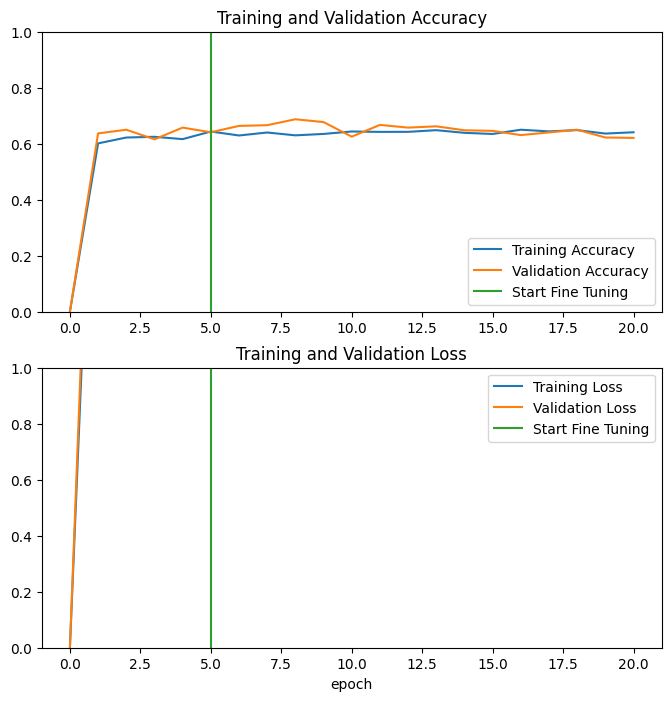

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([5,5],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([5,5],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_dataset = image_dataset_from_directory(test_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             seed=42)

Found 1100 files belonging to 11 classes.


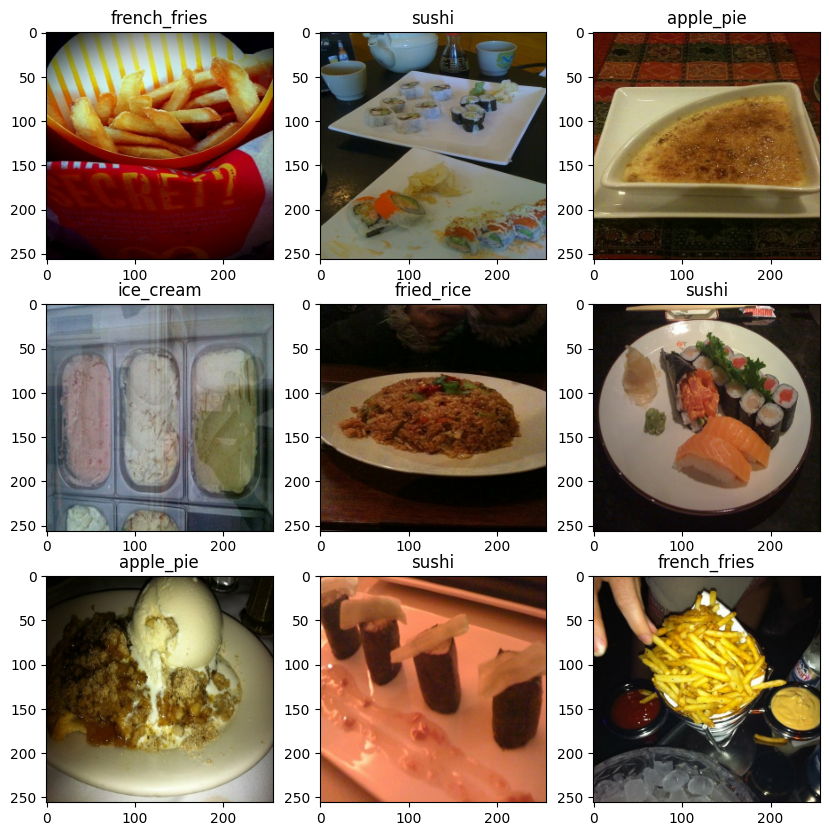

In [ ]:
class_names = test_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("on")

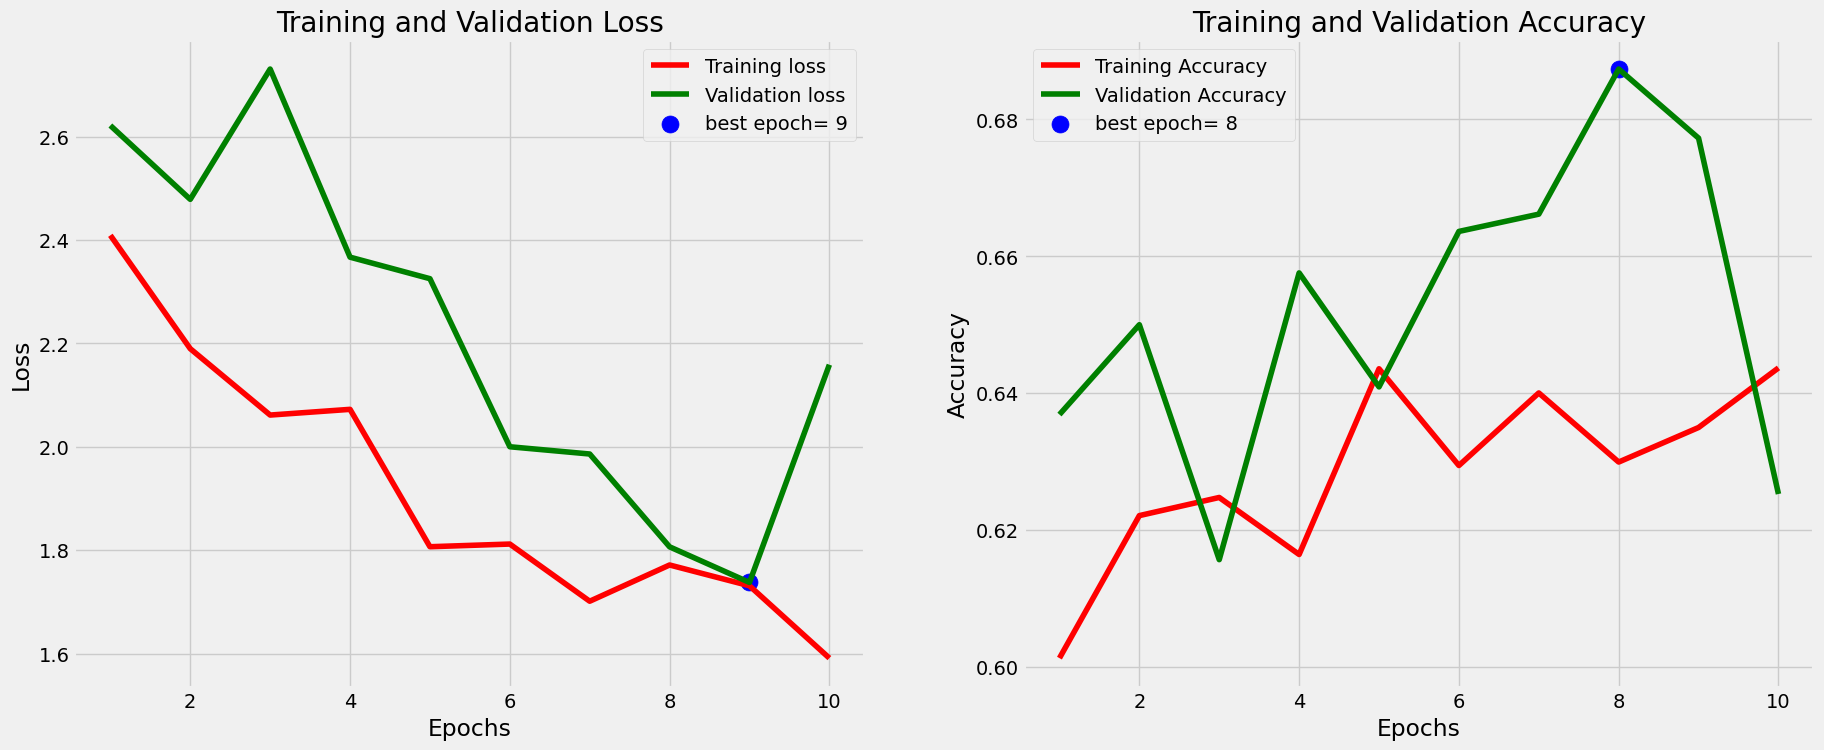

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['sparse_categorical_accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_sparse_categorical_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(history,0)


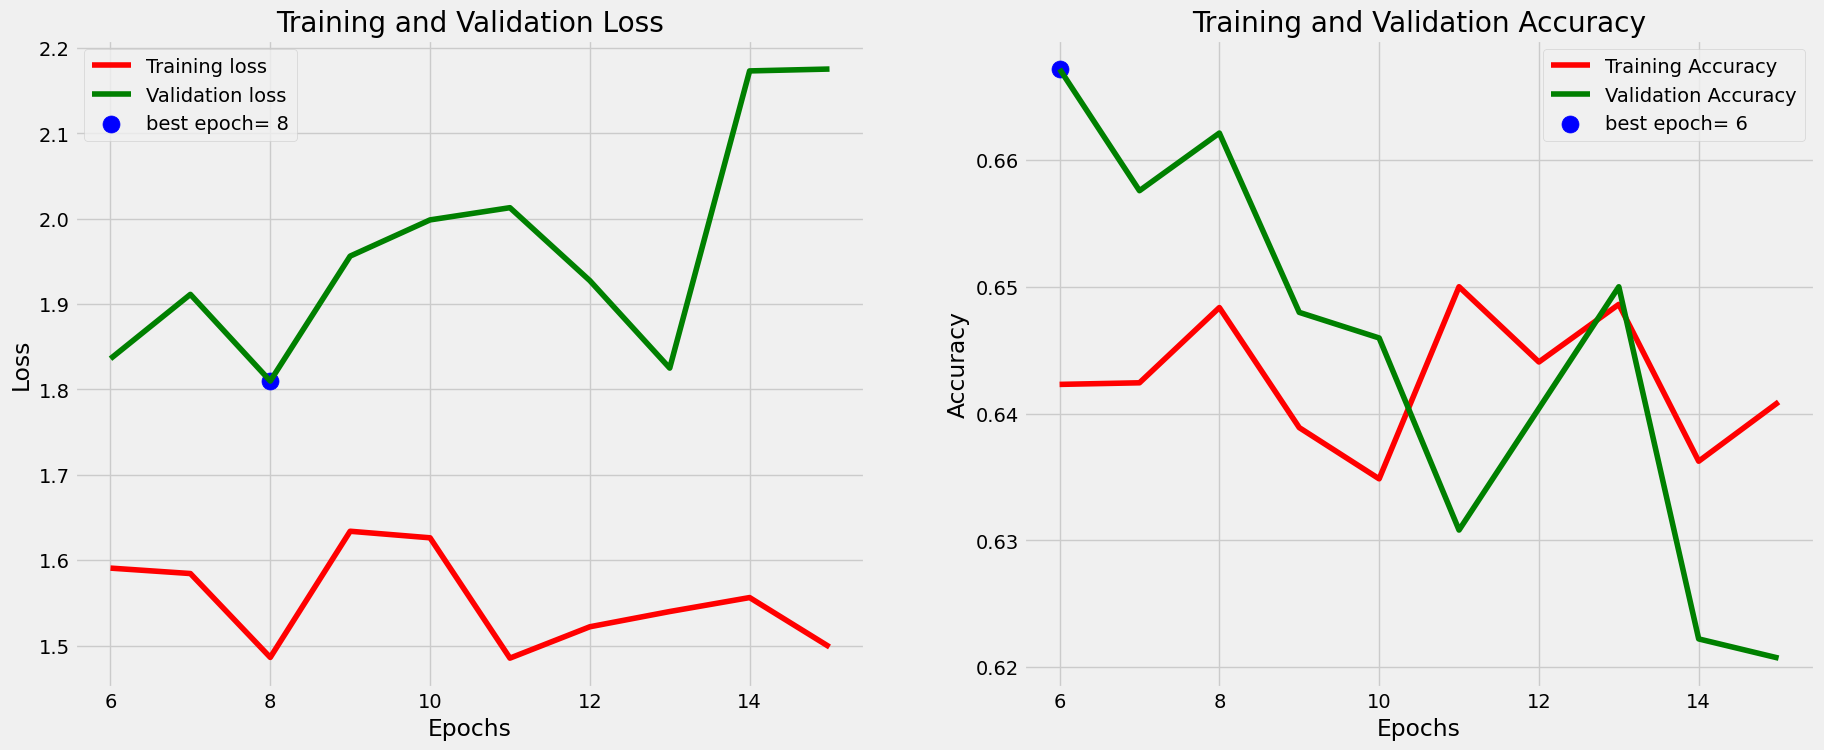

In [ ]:
tr_plot(history_fine,5)